In [1]:
import math
import pandas as pd 
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

import h3 # h3 bins from uber

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [3]:
import sys
sys.path.append('../Scripts')
import capstone_functions as cf

In [4]:
cf.ambulance_placement_pipeline(input_path='../Inputs/', output_path='../Outputs/', crash_source_csv='predictions_for_clustering_c',
                                 outlier_filter=0.005,
                                 holdout_strategy='random', holdout_test_size=0.3,
                                 test_period_date_start='2019-01-01', test_period_date_end='2019-07-01',
                                 tw_cluster_strategy='baseline', placement_method='k_means', verbose=1,
                                 lr=3e-2, n_epochs=400, batch_size=50)

1 clusters created
using k-means clustering
1 placement sets created
Total size of test set: 973
Total size of train set: 3242
Score on test set: 0.046641007602095066
Score on train set: 0.03342126127019406 (avg distance per accident)
20201217_predictions_for_clustering_c_0.005_baseline_k_means.csv saved in ../Outputs/


In [4]:
df_predictions_c = cf.rta_prediction_pipeline(type_of_pred="c", frequency_cutoff=1, predict_period='2019_h1')

file created ../Inputs/predictions_for_clustering_c.csv


In [ ]:
df_predictions_c.head()

In [7]:
def full_pipeline_1(input_path='../Inputs/', output_path='../Outputs/', crash_source_csv='Train',
                                 outlier_filter=0,
                                 test_period_date_start='2019-01-01', test_period_date_end='2019-07-01',
                                 tw_cluster_strategy='baseline', placement_method='k_means', verbose=0,
                                 lr=3e-2, n_epochs=400, batch_size=50):  
    '''
    load crash data (from train or prediction) and apply feautre engineering, run tw clustering (based on strategy choice) 
    create ambulance placements, create output file.
    placement_model has no impact on functions but is used to add info to output file
    '''
    
    # load predicted crash data into dataframe
    crash_df = rta_prediction_pipeline(type_of_pred="c", frequency_cutoff=1, predict_period='2019_h1')
    
    # in case of loading file with hex bins instead of lat/long
    if 'latitude' not in crash_df.columns:
        crash_df['latitude'] = crash_df.hex_bins.apply(lambda x : h3.h3_to_geo(x)[0])
        crash_df['longitude'] = crash_df.hex_bins.apply(lambda x : h3.h3_to_geo(x)[1])  
        crash_df.drop("hex_bins", axis=1, inplace=True)

    # create train dataset from predictions for 2019
    crash_df = create_temporal_features(crash_df)
    train_df = crash_df
    # create test dataset from actual 2019
    test_df = create_crash_df(train_file = '../Inputs/Train.csv')
    test_df = data.loc[data["datetime"] >= "2019-01-01"]
    test_df = create_temporal_features(test_df)
    
    # remove outliers from test set based on lat and lon
    train_df = outlier_removal(train_df, filter=outlier_filter)
    # apply time window cluster labels to df based on strategy specified
    train_df = create_cluster_feature(train_df, strategy=tw_cluster_strategy, verbose=verbose)
    # Run clustering model to get placement set centroids for each TW cluster
    test_df_with_clusters = create_cluster_feature(test_df, strategy=tw_cluster_strategy, verbose=0)
    centroids_dict = create_cluster_centroids(train_df, test_df=test_df_with_clusters, verbose=verbose, method=placement_method,
                                             lr=lr, n_epochs=n_epochs, batch_size=batch_size)
    
    # create df in format needed for submission
    train_placements_df = centroid_to_submission(centroids_dict, date_start='2018-01-01', date_end='2019-12-31',
                                                 tw_cluster_strategy=tw_cluster_strategy)
    
    # Run scoring functions
    if verbose > 0:    
        print(f'Total size of test set: {test_df.shape[0]}')
    test_score = score(train_placements_df, test_df, test_start_date=test_period_date_start,
                       test_end_date=test_period_date_end)
    if verbose > 0:    
        print(f'Total size of train set: {crash_df.shape[0]}')
    train_score = score(train_placements_df,train_df,
                        test_start_date=test_period_date_start, test_end_date=test_period_date_end)
    if verbose > 0:    
        print(f'Score on test set: {test_score / max(test_df.shape[0],1)}')
    if verbose > 0:    
        print(f'Score on train set: {train_score / train_df.shape[0] } (avg distance per accident)')

    # Create file for submitting to zindi
    submission_df = centroid_to_submission(centroids_dict, date_start='2019-07-01', date_end='2020-01-01',
                                           tw_cluster_strategy=tw_cluster_strategy)
    create_submission_csv(submission_df, crash_source=crash_source_csv, outlier_filter=outlier_filter,
                          tw_cluster_strategy=tw_cluster_strategy, placement_method=placement_method, path=output_path ,verbose=verbose)

    
    

file created ../Inputs/predictions_for_clustering_c.csv
1 clusters created
using k-means clustering


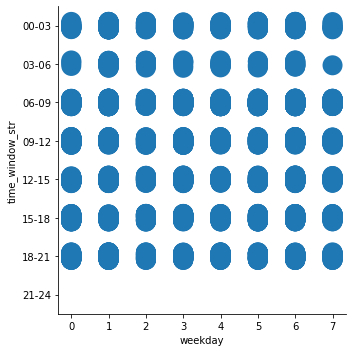

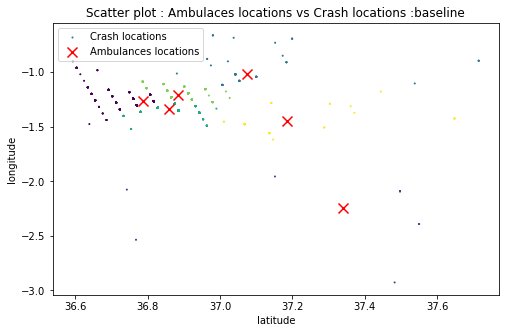

1 placement sets created
Total size of test set: 1922
Total size of train set: 3227
Score on test set: 0.057185595820810446
Score on train set: 0.04962934217457604 (avg distance per accident)
20201217_prediction_0.0_baseline_k_means.csv saved in ../Outputs


In [6]:
cf.full_pipeline(frequency_cutoff=0, outlier_filter=0.000, test_period_date_start='2019-01-01', test_period_date_end='2019-07-01',
                                 tw_cluster_strategy='baseline', placement_method='k_means', verbose=5,
                                 lr=3e-2, n_epochs=400, batch_size=50)

file created ../Inputs/predictions_for_clustering_c.csv
1 clusters created
using k-medoids clustering


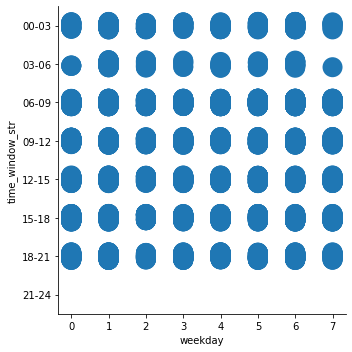

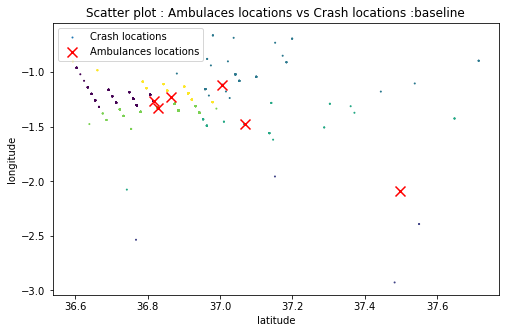

1 placement sets created
Total size of test set: 1922
Total size of train set: 3227
Score on test set: 0.05799315366724311
Score on train set: 0.042152101030195246 (avg distance per accident)
20201217_prediction_0.0_baseline_k_medoids.csv saved in ../Outputs


In [8]:
cf.full_pipeline(frequency_cutoff=0, outlier_filter=0.000, test_period_date_start='2019-01-01', test_period_date_end='2019-07-01',
                                 tw_cluster_strategy='baseline', placement_method='k_medoids', verbose=5,
                                 lr=3e-2, n_epochs=400, batch_size=50)

file created ../Inputs/predictions_for_clustering_c.csv
1 clusters created
using k-medoids clustering


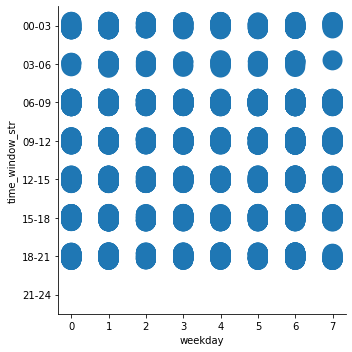

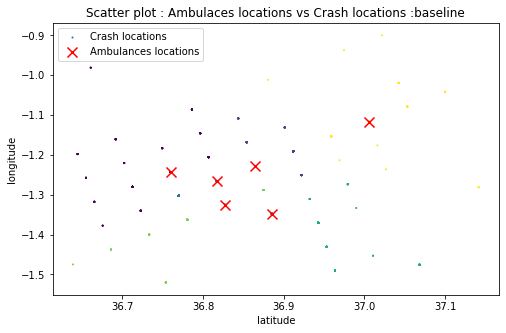

1 placement sets created
Total size of test set: 1922
Total size of train set: 3227
Score on test set: 0.05434649747560321
Score on train set: 0.024828434458494794 (avg distance per accident)
20201217_prediction_0.005_baseline_k_medoids.csv saved in ../Outputs


In [9]:
cf.full_pipeline(frequency_cutoff=0, outlier_filter=0.005, test_period_date_start='2019-01-01', test_period_date_end='2019-07-01',
                                 tw_cluster_strategy='baseline', placement_method='k_medoids', verbose=5,
                                 lr=3e-2, n_epochs=400, batch_size=50)

file created ../Inputs/predictions_for_clustering_c.csv
5 clusters created
using gradient descent clustering
Val loss for cluster sunday_busy: 1.138925313949585
Val loss for cluster peak: 0.8069075345993042
Val loss for cluster middle: 0.951176643371582
Val loss for cluster off_peak: 0.8596962690353394
Val loss for cluster saturday_busy: 1.1356425285339355
5 placement sets created
Total size of test set: 1922
Total size of train set: 3227
Score on test set: 0.06110052753481628
Score on train set: 0.028528772547582456 (avg distance per accident)
20201217_prediction_0.005_off_peak_split_gradient_descent.csv saved in ../Outputs/


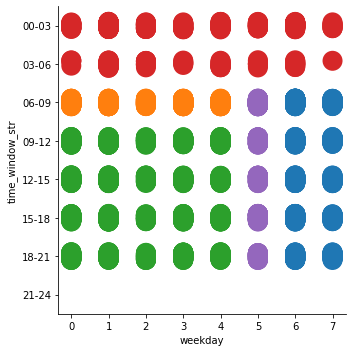

In [6]:
cf.full_pipeline(frequency_cutoff=0, outlier_filter=0.005, test_period_date_start='2019-01-01', test_period_date_end='2019-07-01',
                                 tw_cluster_strategy='off_peak_split', placement_method='gradient_descent', verbose=5,
                                 lr=3e-2, n_epochs=20, batch_size=2)

file created ../Inputs/predictions_for_clustering_c.csv
1 clusters created
using k-means clustering


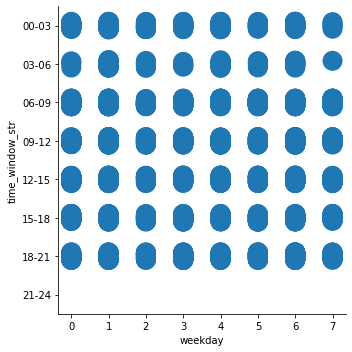

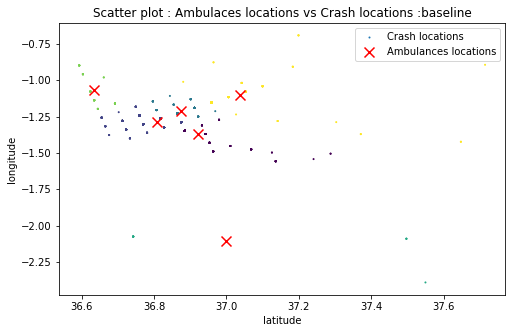

1 placement sets created
Total size of test set: 1922
Total size of train set: 3227
Score on test set: 0.056247557018282456
Score on train set: 0.0484335020395683 (avg distance per accident)
20201217_prediction_0.0_baseline_k_means.csv saved in ../Outputs


In [11]:
cf.full_pipeline(frequency_cutoff=1, outlier_filter=0.000, test_period_date_start='2019-01-01', test_period_date_end='2019-07-01',
                                 tw_cluster_strategy='baseline', placement_method='k_means', verbose=5,
                                 lr=3e-2, n_epochs=400, batch_size=50)

file created ../Inputs/predictions_for_clustering_c.csv
1 clusters created
using k-means clustering


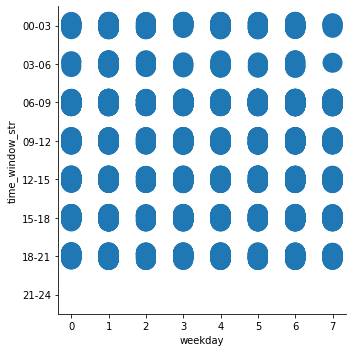

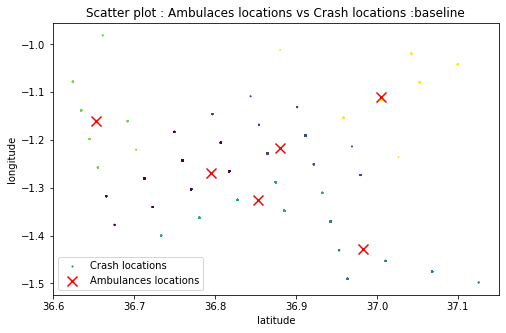

1 placement sets created
Total size of test set: 1922
Total size of train set: 3227
Score on test set: 0.052458804231473304
Score on train set: 0.03671799876260015 (avg distance per accident)
20201217_prediction_0.005_baseline_k_means.csv saved in ../Outputs


In [12]:
cf.full_pipeline(frequency_cutoff=1, outlier_filter=0.005, test_period_date_start='2019-01-01', test_period_date_end='2019-07-01',
                                 tw_cluster_strategy='baseline', placement_method='k_means', verbose=5,
                                 lr=3e-2, n_epochs=400, batch_size=50)

file created ../Inputs/predictions_for_clustering_c.csv
3 clusters created
using k-means clustering


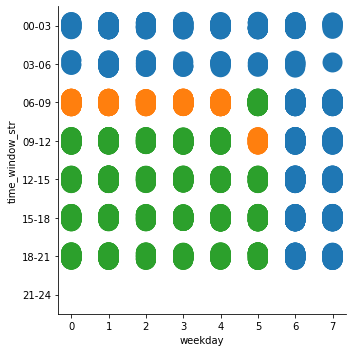

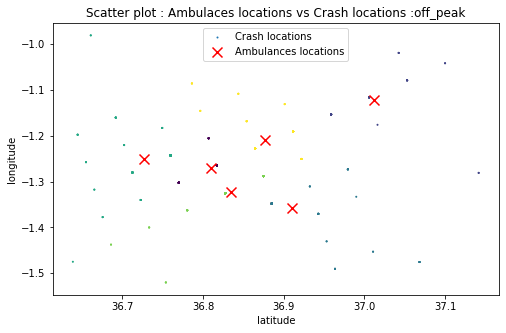

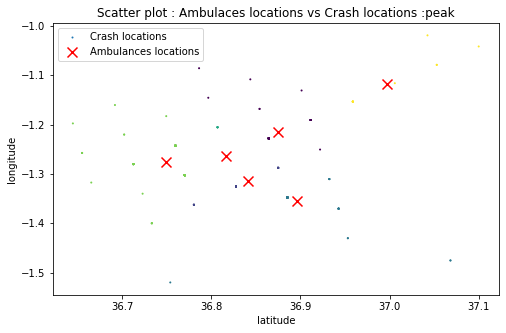

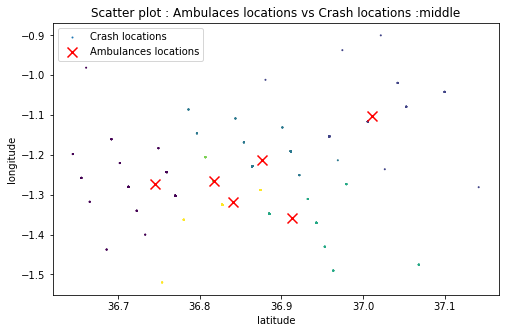

3 placement sets created
Total size of test set: 1922
Total size of train set: 3227
Score on test set: 0.051911654252313026
Score on train set: 0.0296977335206244 (avg distance per accident)
20201217_prediction_0.005_mean_shift_modified_k_means.csv saved in ../Outputs


In [15]:
cf.full_pipeline(frequency_cutoff=0, outlier_filter=0.005, test_period_date_start='2019-01-01', test_period_date_end='2019-07-01',
                                 tw_cluster_strategy='mean_shift_modified', placement_method='k_means', verbose=5,
                                 lr=3e-2, n_epochs=400, batch_size=50)